In [1]:
import numpy as np
import pickle
import keras.backend as K

from keras.layers import  GlobalAveragePooling1D, Input, Activation, MaxPooling1D, BatchNormalization, Dense, Dropout, Conv1D,GlobalMaxPooling1D
from keras.layers import GRU,AveragePooling1D,CuDNNGRU
from keras.layers.merge import Concatenate
from keras.models import Model 
from keras.callbacks import EarlyStopping,ModelCheckpoint

import keras.backend.tensorflow_backend as KTF
import tensorflow as tf
import os


os.environ["CUDA_VISIBLE_DEVICES"] = "1"

config = tf.ConfigProto()
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
sess = tf.Session(config=config)

KTF.set_session(sess)

Using TensorFlow backend.
/home/xhh/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/xhh/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/xhh/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/xhh/anaconda3/envs/py36/lib/p

In [2]:
import numpy as np
alphabet = np.array(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
                     'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'])

def label_sequence(line, MAX_SEQ_LEN, smi_ch_ind):
	X = np.zeros(MAX_SEQ_LEN)

	for i, ch in enumerate(line[:MAX_SEQ_LEN]):
		X[i] = smi_ch_ind[ch]

	return X #.tolist()

def letter_one_hot(aa):
    one_hot = np.zeros(20)
    for idx, letter in enumerate(alphabet):
        if aa == letter:
            one_hot[idx] = 1
            return one_hot


# Convert an entire protein to one-hot representation.
def protein_one_hot(protein_sequence, MAX_SEQ_LEN):
    #  Remove non-specific AA codes (very few are actually present in this dataset)
    protein_sequence = protein_sequence.replace('B', '')
    protein_sequence = protein_sequence.replace('J', '')
    protein_sequence = protein_sequence.replace('O', '')
    protein_sequence = protein_sequence.replace('U', '')
    protein_sequence = protein_sequence.replace('X', '')
    protein_sequence = protein_sequence.replace('Z', '')
    one_hot_seq = np.zeros( (MAX_SEQ_LEN, 20))
    for idx, aa in enumerate(protein_sequence[:MAX_SEQ_LEN]):
        one_hot_seq[idx, :] = letter_one_hot(aa)
    return one_hot_seq


In [3]:
import keras
feature_len = 768
max_go_len = 128
max_seq_len = 1000

from six.moves import cPickle as pickle #for performance

 
def save_dict(di_, filename_):
    with open(filename_, 'wb') as f:
        pickle.dump(di_, f)

def load_dict(filename_):
    with open(filename_, 'rb') as f:
        ret_di = pickle.load(f)
    return ret_di

protein2go =  load_dict('SC_protein2go_dicts.pkl')
protein2seq = load_dict('SC_protein_seqs.pkl')

prot2emb = {}
for key, value in protein2go.items():
    X_go1 =  np.zeros((1,768))
    allgos = value.split(';') 
    allgos = list(set(allgos))
    count = 0
    for  go in  allgos:
        feature = np.load('ncbi_allfeatures4go/'+go+'_0.npy')[1:-1]
        if count + feature.shape[0] > max_go_len:
            break
        X_go1 = np.concatenate((X_go1,feature ))    
        count += feature.shape[0]
    prot2emb[key] =  X_go1[1:] 
protein2onehot = {}
for key, value in protein2seq.items():
    protein2onehot[key] =  protein_one_hot(value, max_seq_len)
        
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self,  ppi_pair_file, batch_size=128):
        'Initialization' 
        self.batch_size = batch_size
        self.ppi_pair_file = ppi_pair_file
         
        self.max_seqlen = max_seq_len
        self.max_golen = max_go_len
        self.protein2go =  load_dict('SC_protein2go_dicts.pkl')
        self.protein2seq = load_dict('SC_protein_seqs.pkl')
        self.read_ppi()
        self.protein2onehot = protein2onehot
        self.prot2emb = prot2emb
#         self.onehot_seqs()
#         self.prot2embedding() 
        self.on_epoch_end()
    
    def read_ppi(self):
        with open(self.ppi_pair_file, 'r') as f:
            self.ppi_pairs  =  f.readlines()
    

   

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.ppi_pairs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.ppi_pairs))
         
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization

        X_go1 = np.empty((self.batch_size, self.max_golen,768))
        X_seq1 = np.empty((self.batch_size, self.max_seqlen,20))

        X_go2 = np.empty((self.batch_size, self.max_golen,768))
        X_seq2 = np.empty((self.batch_size, self.max_seqlen,20))
        y = np.empty((self.batch_size))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            ppi_pair = self.ppi_pairs[ID]
            p1, p2, label = ppi_pair.rstrip().split(',')
            if label == '1':
                y[i] = 1
            else:
                y[i] = 0
            
            X_seq1[i] =  self.protein2onehot[p1]
            X_seq2[i] =  self.protein2onehot[p2]
            
            prot1emb = self.prot2emb[p1]
            X_go1[i,:prot1emb.shape[0]] = prot1emb
            
            prot2emb = self.prot2emb[p2]
            X_go2[i,:prot2emb.shape[0]] = prot2emb
            

        return [X_go1,X_go2, X_seq1, X_seq2] ,  y



    def all_data(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization

        X_go1 = np.empty((len(list_IDs_temp), self.max_golen,768))
        X_seq1 = np.empty((len(list_IDs_temp), self.max_seqlen,20))

        X_go2 = np.empty((len(list_IDs_temp), self.max_golen,768))
        X_seq2 = np.empty((len(list_IDs_temp), self.max_seqlen,20))
        y = np.empty((len(list_IDs_temp)))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            ppi_pair = self.ppi_pairs[ID]
            p1, p2, label = ppi_pair.rstrip().split(',')
            if label == '1':
                y[i] = 1
            else:
                y[i] = 0
            
 
            X_seq1[i] =  self.protein2onehot[p1]
            X_seq2[i] =  self.protein2onehot[p2]
            prot1emb = self.prot2emb[p1]
            X_go1[i,:prot1emb.shape[0]] = prot1emb
            
            prot2emb = self.prot2emb[p2]
            X_go2[i,:prot2emb.shape[0]] = prot2emb
            
        return [X_go1,X_go2, X_seq1, X_seq2] ,  y

In [4]:
from keras import backend as K, initializers, regularizers, constraints
from keras.engine.topology import Layer


def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        # todo: check that this is correct
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)


class Attention(Layer):
    def __init__(self,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True,
                 return_attention=False,
                 **kwargs):
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Note: The layer has been tested with Keras 1.x
        Example:
            # 1
            model.add(LSTM(64, return_sequences=True))
            model.add(Attention())
            # next add a Dense layer (for classification/regression) or whatever...
            # 2 - Get the attention scores
            hidden = LSTM(64, return_sequences=True)(words)
            sentence, word_scores = Attention(return_attention=True)(hidden)
        """
        self.supports_masking = True
        self.return_attention = return_attention
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        eij = dot_product(x, self.W)

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        weighted_input = x * K.expand_dims(a)

        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return input_shape[0], input_shape[-1]

In [5]:
from keras.layers import   Embedding
from keras.layers import  GRU, Bidirectional, CuDNNGRU, Lambda, Flatten
from keras.utils import multi_gpu_model
from keras.layers.merge import concatenate
from keras_radam import RAdam
from keras_lookahead import Lookahead


def inception_block(input_tensor, output_size):
    """"""
    con1d_filters = int(output_size/4)
    y = Conv1D(con1d_filters, 3, activation="relu", padding='same')(input_tensor)
    x1 = Conv1D(con1d_filters, 5, activation="relu", padding='same')(y)

    y = Conv1D(con1d_filters, 1, activation="relu", padding='valid')(input_tensor)
    x2 = Conv1D(con1d_filters, 3, activation="relu", padding='same')(y)

    x3 = Conv1D(con1d_filters, 3, activation="relu", padding='same')(input_tensor)
    x4 = Conv1D(con1d_filters, 1, activation="relu", padding='same')(input_tensor)

    y = Concatenate()([x1, x2, x3, x4])
#     y = MaxPooling1D(4)(mix0)
    # y = AveragePooling1D()(mix0)
#     y = BatchNormalization()(y)

    return y


def build_cnn_gru_model(input_x, con_filters, gru_units):
    x = inception_block(input_x,con_filters )
    x = Dropout(0.3)(x)
    x_gru = Bidirectional(CuDNNGRU(gru_units, return_sequences=True))(input_x)
    x_gru = Dropout(0.3)(x_gru)
     
    x_a = GlobalAveragePooling1D()(x)
    x_b = GlobalMaxPooling1D()(x)
    x_c = Attention()(x)
    x_gru_a = GlobalAveragePooling1D()(x_gru)
    x_gru_b = GlobalMaxPooling1D()(x_gru)
    x_gru_c = Attention()(x_gru)
    x = Concatenate()([x_a, x_b, x_c, x_gru_a, x_gru_b,   x_gru_c])
    x = Dense(256,activation='relu')(x)
    return x



def build_model():
    con_filters = 256
    gru_units = 64
    left_input_go = Input(shape=(max_go_len,feature_len))
    right_input_go = Input(shape=(max_go_len,feature_len))
    
    
    left_input_seq = Input(shape=(max_seq_len,20))
    right_input_seq = Input(shape=(max_seq_len,20))
    
     
 
     
    left_x_go = build_cnn_gru_model(left_input_go, con_filters, gru_units)
    right_x_go = build_cnn_gru_model(right_input_go, con_filters,gru_units)
    
    left_x_seq = build_cnn_gru_model(left_input_seq, con_filters//4, gru_units)
    right_x_seq = build_cnn_gru_model(right_input_seq, con_filters//4, gru_units)
     
    
   
    x =   Concatenate()([left_x_go  , right_x_go, left_x_seq, right_x_seq])
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(512, activation='relu')(x)
  
     
    x = Dense(1)(x)
    output = Activation('sigmoid')(x)
    # model = Model([left_input_go, right_input_go], output)
  
    model = Model([left_input_go, right_input_go, left_input_seq, right_input_seq], output)
#     model = multi_gpu_model(model, gpus=2)
    optimizer = Lookahead(RAdam())

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


model = build_model()
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 768)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 128, 768)     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1000, 20)     0                                            
___________________________________________________________________________

In [6]:
model.load_weights('SC_CV/sc_GoplusSeq1-0.hdf5')

In [7]:
rep = 1
split = 0
test_pairs_file = 'SC_CV/test'+str(rep)+'-'+str(split)
batch_size = 256
         
test_generator = DataGenerator(   test_pairs_file,batch_size = batch_size)

In [8]:
seq1_output = Model(inputs=model.input,
                                 outputs=model.get_layer('concatenate_6').output)
seq2_output = Model(inputs=model.input,
                                 outputs=model.get_layer('concatenate_8').output)

go1_output = Model(inputs=model.input,
                                 outputs=model.get_layer('concatenate_2').output)
go2_output = Model(inputs=model.input,
                                 outputs=model.get_layer('concatenate_4').output)


In [9]:
with open(test_pairs_file, 'r') as f:
    test_ppi_pairs  =  f.readlines()

test_len = len(test_ppi_pairs) 
list_IDs_temp = np.arange(test_len)
test_x, y_test = test_generator.all_data(list_IDs_temp)

In [10]:
seq1_feature = seq1_output.predict(test_x)
seq2_feature = seq2_output.predict(test_x)
go1_feature = go1_output.predict(test_x)
go2_feature = go2_output.predict(test_x)


In [11]:
print(seq1_feature.shape, seq2_feature.shape, go1_feature.shape, go2_feature.shape)

(8628, 576) (8628, 576) (8628, 1152) (8628, 1152)


In [9]:
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer('dense_7').output)


In [10]:
intermediate_layer_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 768)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 128, 768)     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1000, 20)     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1000, 20)     0                                            
____________________________________________________________________________________________

In [11]:
with open(test_pairs_file, 'r') as f:
    test_ppi_pairs  =  f.readlines()

test_len = len(test_ppi_pairs) 
list_IDs_temp = np.arange(test_len)
test_x, y_test = test_generator.all_data(list_IDs_temp)

In [12]:
y_pred = intermediate_layer_model.predict(test_x)

In [13]:
print(y_pred.shape)

(8628, 512)


In [14]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0, verbose=1, perplexity=40, n_iter=1000)

In [15]:
X_2d = tsne.fit_transform(y_pred)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8628 samples in 0.268s...
[t-SNE] Computed neighbors for 8628 samples in 15.396s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8628
[t-SNE] Computed conditional probabilities for sample 2000 / 8628
[t-SNE] Computed conditional probabilities for sample 3000 / 8628
[t-SNE] Computed conditional probabilities for sample 4000 / 8628
[t-SNE] Computed conditional probabilities for sample 5000 / 8628
[t-SNE] Computed conditional probabilities for sample 6000 / 8628
[t-SNE] Computed conditional probabilities for sample 7000 / 8628
[t-SNE] Computed conditional probabilities for sample 8000 / 8628
[t-SNE] Computed conditional probabilities for sample 8628 / 8628
[t-SNE] Mean sigma: 0.384193
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.444397
[t-SNE] KL divergence after 1000 iterations: 1.133756


In [16]:
from matplotlib import pyplot as plt
%matplotlib inline

colors = 'r',   'b'


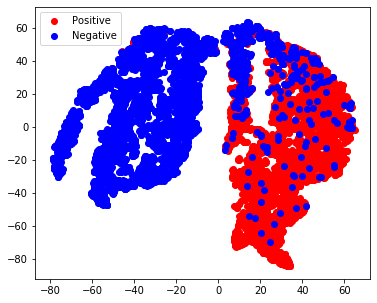

In [17]:
plt.figure(figsize=(6, 5))

for i, c, label in zip([0,1], colors, ['Positive', 'Negative']):
    plt.scatter(X_2d[y_test == i, 0], X_2d [ y_test == i, 1], c=c, label=label)
plt.legend()